In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import keras
import numpy as np
import os, sys
import pandas as pd
import os.path as osp

Using TensorFlow backend.


In [2]:
data_folder = '../Data/Npy/beginning'
fn_prec = '01_prec_training.npy'
fn_temp = '01_temp_training.npy'
fn_mask = '01_mask.npy'
#data_elev = 'Npy/01_dem.npy'
fn_disc = '01_discharge_training.csv'

- import **deephydro module** with networks, losses and metrics

In [3]:
%load_ext autoreload
%autoreload 2
module_folder = os.path.abspath('../src')
#module_folder = 'src/'
if module_folder not in sys.path:
    sys.path.append(module_folder)
import deephydro

#from deephydro.utils import limit_gpu_memory
#limit_gpu_memory()

# Data import

- load output data

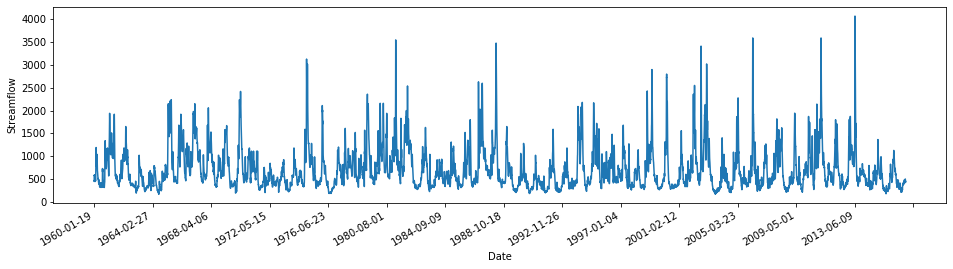

In [4]:
from deephydro import data, visualization
df = data.load_csv_data(data_folder=data_folder, filename=fn_disc)
df.shape
df.head()
visualization.plot_streamflow(df=df, n_labels=20)

- load input data

In [5]:
x_prec = data.load_from_numpy(data_folder, filename=fn_prec)
x_temp = data.load_from_numpy(data_folder, filename=fn_temp)
x_mask = data.load_from_numpy(data_folder, filename=fn_mask)

In [6]:
print(f'x_prec.shape = {x_prec.shape}')
print(f'x_temp.shape = {x_temp.shape}')
print(f'x_mask.shape = {x_mask.shape}')

x_prec.shape = (20802, 53, 66)
x_temp.shape = (20802, 53, 66)
x_mask.shape = (53, 66)


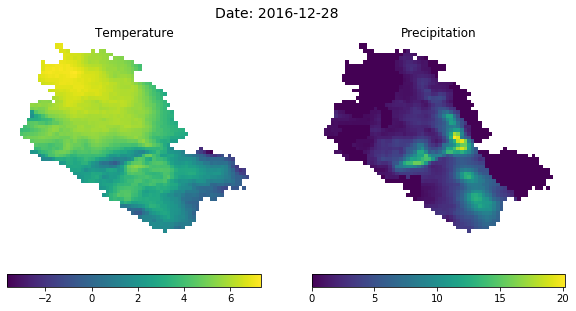

In [7]:
visualization.plot_temp_prec_frame(x_temp, x_prec, x_mask, df, 
                                   frame=-4)


# Data preparation

- define input data `x` and targets `y`

In [8]:
# x: stack temperature and precipitation data
x = np.stack([x_temp, x_prec], axis=-1)

# x: fractional day of year data
x_doy = df['FDOY'].values

# y: streamflow data
y = df['Q'].values

- split train and validation data

In [9]:
# split train and validation data
validation_fraction=0.2
validation_first=False

x_train, x_val, y_train, y_val = \
  data.split_train_validation(x, y, 
                              validation_fraction=validation_fraction,
                              validation_first=validation_first)

x_doy_train, x_doy_val = data.split_DOY_train_validation(x_doy,  
                              validation_fraction=validation_fraction,
                              validation_first=validation_first)

df_train, df_val = data.split_df_train_validation(df, 
                              validation_fraction=validation_fraction,
                              validation_first=validation_first)


In [10]:
print('Shape of x_train = ', x_train.shape)
print('Shape of y_train = ', y_train.shape)
print('Shape of x_val   = ', x_val.shape)
print('Shape of y_val   = ', y_val.shape)

Shape of x_train =  (16642, 53, 66, 2)
Shape of y_train =  (16642,)
Shape of x_val   =  (4160, 53, 66, 2)
Shape of y_val   =  (4160,)


- standardize input (`x_train`) and output data (`y`)
- adjust Walters function so that it returns 

In [11]:
def _standardize_L(data:np.array, logarithm:bool=False, return_moments=False):
    '''Standardize data: zero-centering and dividing by standard deviation.
    
    Args:
        data:np.array
            data to standardize
        logarithm:bool
            if True, logarithmize output (not mean and std) 
        return_moments:bool
            if True, mean and std are returned (useful for rescaling)

    Returns:
        np.array
            standardized data
        tuple
            if `return_moments=True`, mean and standard deviation
    '''
    if logarithm:#only works for discharge
        data=np.log(data)
    
    mean = np.mean(data)
    std = np.std(data)
    standardized = (data-mean)/std
    if return_moments:        
        return standardized, (mean, std)
    else:
        return standardized

In [12]:
#train
x_train[:,:,:,0], moments_temp = _standardize_L(x_train[:,:,:,0],return_moments=True)
print(moments_temp)
x_train[:,:,:,1], moments_prec = _standardize_L(x_train[:,:,:,1],return_moments=True)
print(moments_prec)
#val
x_val[:,:,:,0] = (x_val[:,:,:,0]-moments_temp[0])/moments_temp[1]
x_val[:,:,:,1] = (x_val[:,:,:,1]-moments_prec[0])/moments_prec[1]

(3.9268024, 6.7914157)
(0.80708367, 2.7563758)


In [13]:
max(y_train)

3550.0

In [14]:
y_train, moments_y = _standardize_L(y_train,logarithm=True, return_moments=True)
y_val = np.log(y_val)
y_val = (y_val-moments_y[0])/moments_y[1]
print(moments_y)

(6.408481852799951, 0.5569629185597191)


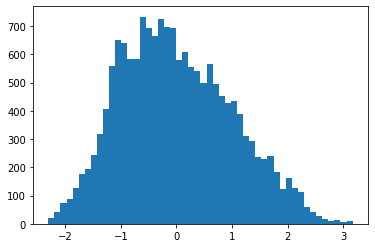

In [15]:
_ = plt.hist(y_train, bins=50)

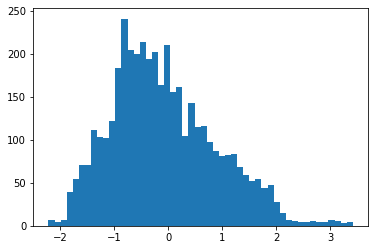

In [16]:
_ = plt.hist(y_val, bins=50)

## Data generator

To sample image sequences, we do not store of all possible image sequences to memory. This would imply storing a lot of overlapping (=redundant) data.

Instead, we use a generator to generate a batch of random sequences. We could build a simple generator function using the `yield` statement, but to exploit parallel processing during batch generation, we will extend the `keras.utils.Sequence` class. 

In [17]:
from keras import utils
import numpy as np
import pandas

class ImageSequenceGenerator_L(utils.Sequence):
    '''Generates sequential (!) image sequences
    
    Supports:
    - uncertainty
    Does not support:
    - forecasting
    - day of year
    
    - Disgards targets of a n_frame buffer in first batch (beacuse there is not input data)
    - Puts into last batch whatever is left, so last batch is probably smaller
    '''
    def __init__(self, data:np.array, labels:np.array, batch_size:int, 
                 n_frames:int, stride:int=1, 
                 doy:np.array=None, day_of_year:bool=True, 
                 uncertainty:bool=False, randomseed=None):
        '''
        Args:
            data:np.array
                Data set to sample from (x_train or x_test), shape=(N, H, W, C)
            labels:np.array
                Labels to sample from (y_train or y_test), shape=(N,)
            batch_size:int
                Batch size
            n_frames:int
                Number of consecutive frames in sample. Note: if `forecasting=True`, this also is the length of forecast
            stride:int
                step size between frames (default=1)
            doy:np.array,
                Data set of fractional day of year, shape=(N,)
            day_of_year:bool,
                Use fractional day of year. 
            uncertainty:bool
                Whether generator is used in uncertainty model. If `true`, adds dimension to labels to have same dimensionality as predictions.
            randomseed: int or None
                If not None, sets random seed
        '''
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.n_frames = n_frames
        self.stride = stride
        self.uncertainty = uncertainty
        self.doy = doy
        self.day_of_year = day_of_year
        self.randomseed = randomseed
        
        if self.randomseed is not None:
            np.random.seed(self.randomseed)

        assert len(self.data) == len(self.labels)
        if self.day_of_year:
            assert len(self.doy) == len(self.data)
            

    def __len__(self):
        '''Denotes the number of batches per epoch'''
        return int((np.floor(len(self.data)-n_frames) / self.batch_size))

    def __getitem__(self, index):
        '''Generate one batch of data'''
        
        batch_x, batch_y = [], []
        if self.day_of_year: batch_x_doy = []
        
        # start of timeseries: smaller as there is a n_frames-buffer at the start
        #if index == 0:
        start_batch = index*self.batch_size
        end_batch = (index+1)*self.batch_size#add frames to have n frames buffer at end
        # e.g. second batch: sample back into the region of first batch
        #else:
        #    start_batch = index*self.batch_size-self.n_frames
        #    end_batch = (index+1)*self.batch_size-self.n_frames
        #    #last batch is longer to contain the n_frame-buffer at the end
        if index == self.__len__():
            start_batch = index*self.batch_size
            end_batch = len(self.labels)-self.n_frames
        
        batch_indices = np.arange(start_batch,end_batch,1)
        #batch_indices = batch_indices[:(len(batch_indices)-4)]#Why does this work now?
        
        for i in (batch_indices):
            # Get start index of sequence
            start_index = i
            stop_index  = i+self.n_frames

            # x = image sequence
            x = self.data[start_index:(stop_index+1)]#+1 because of non-inclusive indexing
            # y = streamflow at end point
            y = self.labels[stop_index]
            batch_x.append(x)
            batch_y.append(y)
            
            if self.day_of_year: 
                batch_x_doy.append( self.doy[stop_index])

        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)

        if self.uncertainty:
            # in case we are training a model with uncertainty
            # add an axis to make the targets y_true the same dimensionality as the predictions y_pred
            batch_y = batch_y[..., np.newaxis] # add axis
        
        if self.day_of_year:
            batch_x_doy = np.array(batch_x_doy)
            return [batch_x, batch_x_doy], batch_y,self.__len__()#index, start_batch, end_batch
        else:
            return batch_x, batch_y



In [19]:
# length of image sequence
n_frames = 30
# number of GPUs
n_gpus = 4

batch_size = 92*n_gpus
n_batch = len(y_train)//batch_size
print("N Batches: "+str(n_batch))
print("Datapoints dropped at the end of timeseries: "+str(len(y_train)%batch_size))

end_index = batch_size * n_batch
print(str(end_index))
val = end_index%batch_size
print("Points left over after chopping: "+str(val))
#y_train = y_train[:(end_index+1)]
#x_train = x_train[:(end_index+1)]


N Batches: 45
Datapoints dropped at the end of timeseries: 82
16560
Points left over after chopping: 0


In [20]:

# adjust this to available GPU memory (VRAM)
# length data has to be dividable by batch_size
# previously 92*4=368, so 16642/368= 45,2 batches
#batch_size = (len(y_train)-n_frames)/43
#print(batch_size)

# use day of year ?
day_of_year = True
# forecasting ?
forecasting = False
# uncertainty estimation ?
uncertainty = False


In [21]:
#from deephydro.generator import ImageSequenceGenerator
generator_train = ImageSequenceGenerator_L(data=x_train, labels=y_train,
                                         doy=x_doy_train, day_of_year=day_of_year,
                                         batch_size=batch_size, n_frames=n_frames,
                                         stride=1)
generator_test  = ImageSequenceGenerator_L(data=x_val, labels=y_val,   
                                         doy=x_doy_val, day_of_year=day_of_year,
                                         batch_size=batch_size, n_frames=n_frames,
                                         stride=1)

- try the sequence generator

In [235]:
batch_size = 4
n_frames = 4
day_of_year = True
y_try = np.arange(1,101,1)
x_try = np.arange(1,101,1)
x_doy_try = np.repeat(1,100)
n_batches=int(len(x_try)/batch_size)
print(n_batches)
generator_try = ImageSequenceGenerator_L(data=x_try, labels=y_try,doy=x_doy_try,
                                         day_of_year=day_of_year,batch_size=batch_size,
                                         n_frames=n_frames,stride=1)
for i in range(n_batches): 
    batch = generator_try.__getitem__(i)
    #print(batch)

25


In [22]:
print(len(y_train)/batch_size)
print(len(y_train))
batch = generator_train.__getitem__(44)
#print(batch)
if day_of_year:
    print(f'Shape of batch_x im  = {batch[0][0].shape}')
    print(f'Shape of batch_x doy = {batch[0][1].shape}')
    print(f'Shape of batch_y     = {batch[1].shape}')
else:
    print(f'Shape of batch_x = {batch[0].shape}')
    print(f'Shape of batch_y = {batch[1].shape}')

45.22282608695652
16642
Shape of batch_x im  = (368, 31, 53, 66, 2)
Shape of batch_x doy = (368,)
Shape of batch_y     = (368,)


# Model

- load model
- predicts the streamflow from a short sequence of temperature and precipitation...

In [41]:
def feature_extractor(input_shape:tuple, n_layers:int=3, n_filters:int=16, batch_norm:bool=False, dropout_rate:float=0.0, conv2D_preprocessing=True,stateful=False, batch_shape:int=40):
    '''
    Feature extraction ConvLSTM model, used by all models below.

    Args:
        input_shape: tuple
            shape of input tensor without batch size: (n_frames, height, width, channels)
        n_layers: int
            number of ConvLSTM layers
        n_filters: int
            number of filters in first ConvLSTM layer (multiplied by 2 for every subsequent downsampled layer)
        batch_norm: bool
            use batch normalization (can we do this with ConvLSTMs?)
        dropout_rate: float
            dropout rate
        conv2D_preprocessing: bool
            if True, add time-distributed conv2d layers for preprocessing

    '''
    
    init_n_filters = n_filters

    from keras import layers, models
    i = layers.Input(shape=input_shape, name='images', batch_shape=batch_shape) # (?, n_frames, height, width, channels)
    x = i

    # convolutional preprocessing layers
    if conv2D_preprocessing:
        for _ in range(2):
            x = layers.TimeDistributed( layers.Conv2D(n_filters, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))(x)
            n_filters *= 2
    
        #n_filters = init_n_filters
        n_filters //= 2
    
    # convolutional LSTM layers    
    for _ in range(n_layers):
        # these ConvLSTM layers output sequence: `return_sequences=True`
        x = layers.ConvLSTM2D(n_filters, kernel_size=(3,3), strides=(2,2),
                              activation='tanh', recurrent_activation='hard_sigmoid',
                              return_sequences=True, stateful=stateful)(x)
        if dropout_rate > 0.:
            x = layers.Dropout(rate=dropout_rate)(x)
        if batch_norm:
            x = layers.BatchNormalization()(x)
        n_filters *= 2

    model = models.Model(inputs=[i], outputs=[x], name='feature extractor')
    return model, n_filters

In [42]:
def nowcasting_model(input_shape:tuple, n_layers:int=3, n_filters:int=16, 
                     dropout_rate:float=0.5, dayofyear:bool=False, 
                     batch_norm:bool=True, conv2D_preprocessing:bool=True, stateful=False, batch_shape:int=40):
    '''ConvLSTM model to predict streamflow from image sequence (nowcasting)

    Use with losses.mse, losses.logcosh or losses.huber'''

    from keras import layers, models
    fe, n_filters = feature_extractor(input_shape, n_layers, n_filters,
                                     dropout_rate=dropout_rate,
                                     batch_norm=batch_norm,
                                     conv2D_preprocessing=conv2D_preprocessing, stateful=stateful, batch_shape=batch_shape)
    x = fe.output

    # this ConvLSTM layer only returns value for last point in sequence: `return_sequence = False`
    x = layers.ConvLSTM2D(n_filters, kernel_size=(3,3), strides=(2,2),
                         activation='tanh', recurrent_activation='hard_sigmoid', return_sequences=False,
                         stateful=stateful)(x)

    x = layers.Flatten()(x)

    if dayofyear:
        i = layers.Input((1,), name='day_of_year')
        doy = layers.Dense(32, activation='relu')(i)
        x = layers.Concatenate(axis=-1)([x, doy])

    units = int(256*(1.0/dropout_rate))
    print(units)
    x = layers.Dense(units if not dayofyear else units+32, activation='relu')(x)
    x = layers.Dropout(rate=dropout_rate)(x)
    o = layers.Dense(1, activation='linear')(x)

    if dayofyear:
        model = models.Model(inputs=[fe.input, i], outputs=[o])
    else:
        model = models.Model(inputs=[fe.input], outputs=[o])
    return model

In [46]:
input_shape = (n_frames, *x_train.shape[1:])
from deephydro import networks
model = nowcasting_model(input_shape, n_filters=16, dayofyear=day_of_year,
                                  dropout_rate=0.5, 
                                  batch_norm=True,
                                  conv2D_preprocessing=True, stateful=True, batch_shape=batch_size)
model.summary(line_length=120)

TypeError: 'int' object is not iterable

- compile model: loss, optimizer and metrics

In [104]:
from keras import optimizers
from deephydro.losses import mse, logcosh, gauss
from deephydro.metrics import ccc

def build_model(model, 
                loss,
                metrics=ccc,
                optimizer=optimizers.Adam(lr=1e-3), 
                n_gpus:int=1):
    if n_gpus > 1:
        from keras.utils import multi_gpu_model
        parallel_model = multi_gpu_model(model, gpus=n_gpus)
        parallel_model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])
        return parallel_model
    else:
        model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])
        return model


# Training

In [105]:
n_epochs = 4

In [106]:
from deephydro.utils import checkpointer, early_stopping, reduce_learning_rate
model_name = '../output/model_L.h5'
#callbacks = [checkpointer('../output/model.h5'), early_stopping(), reduce_learning_rate()]
callbacks = [checkpointer(model_name), early_stopping(), reduce_learning_rate()]

In [107]:
if n_gpus > 1:
    parallel_model = build_model(model, loss=mse, n_gpus=n_gpus)
    parallel_model.summary(line_length=120)
    history = parallel_model.fit_generator(
                              # training
                              generator=generator_train,
                              steps_per_epoch=len(x_train)//batch_size,
                              epochs=n_epochs,
                              # validation
                              validation_data=generator_test,
                              validation_steps=len(x_val)//batch_size,
                              # callbacks
                              callbacks=callbacks,
                              # CPU parallelism 
                              use_multiprocessing=False,
                              #workers=2, # if too large, you'll get CPU memory issues (job gets killed)
                              #max_queue_size=10
                              )
else:
    model = build_model(model, loss=mse, n_gpus=n_gpus)
    model.summary(line_length=120)
    history = model.fit_generator(
                              # training
                              generator=generator_train,
                              steps_per_epoch=len(x_train)//batch_size,
                              epochs=n_epochs,
                              # validation
                              validation_data=generator_test,
                              validation_steps=len(x_val)//batch_size,
                              # callbacks
                              callbacks=callbacks,
                              # CPU parallelism 
                              #use_multiprocessing=False,
                              #workers=12,
                              #max_queue_size=10
                              )

W0912 12:36:26.217343 35184372383840 deprecation_wrapper.py:119] From /software/ml/JupyterHub/conda-powerai/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0912 12:36:38.012357 35184372383840 deprecation_wrapper.py:119] From /software/ml/JupyterHub/conda-powerai/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
images (InputLayer)                    (None, 20, 53, 66, 2)      0                                                     
________________________________________________________________________________________________________________________
day_of_year (InputLayer)               (None, 1)                  0                                                     
________________________________________________________________________________________________________________________
lambda_1 (Lambda)                      (None, 20, 53, 66, 2)      0             images[0][0]                            
________________________________________________________________________________________________________________________
lambda_2 (Lambda)               

W0912 12:36:38.866436 35184372383840 deprecation.py:323] From /software/ml/JupyterHub/conda-powerai/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/4
45/45 [==============================] - 57s 1s/step - loss: 1.3506 - ccc: 0.4138 - val_loss: 1.1728 - val_ccc: 0.4503

Epoch 00001: val_loss improved from inf to 1.17280, saving model to ../output/model_L.h5
Epoch 2/4
45/45 [==============================] - 32s 722ms/step - loss: 0.5772 - ccc: 0.5943 - val_loss: 3.4143 - val_ccc: 0.1932

Epoch 00002: val_loss did not improve from 1.17280
Epoch 3/4
45/45 [==============================] - 33s 722ms/step - loss: 0.5314 - ccc: 0.6403 - val_loss: 2.2783 - val_ccc: 0.2148

Epoch 00003: val_loss did not improve from 1.17280
Epoch 4/4
45/45 [==============================] - 32s 719ms/step - loss: 0.4830 - ccc: 0.6793 - val_loss: 3.8925 - val_ccc: 0.1914

Epoch 00004: val_loss did not improve from 1.17280

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


In [108]:
from deephydro import visualization
visualization.plot_history(history)

# Predict

-----

**To do predictions, please use the [predict.ipynb]('./predict.ipynb') notebook.**

-----


In [ ]:
reload_model = True

if reload_model:
    from keras.models import load_model
    from deephydro.metrics import ccc
    model = load_model(model_name, 
               custom_objects={'ccc': ccc})

In [ ]:
# from deephydro.utils import predict
# batch = generator_test.__getitem__(0)
# im = batch[0][0]
# gt = batch[1][0] * Y_STD + Y_MEAN
# y_pred = predict(model, image=im, y_mean=Y_MEAN, y_std=Y_STD)
# print(f'Predicted: {y_pred:.2f}, True: {gt:.2f}, Error: {abs(y_pred-gt):.2f}')

In [ ]:
x_val.shape

- predict time series

0 / 3801
256 / 3801
512 / 3801
768 / 3801
1024 / 3801
1280 / 3801
1536 / 3801
1792 / 3801
2048 / 3801
2304 / 3801
2560 / 3801
2816 / 3801
3072 / 3801
3328 / 3801
3584 / 3801
3801
3801
3801


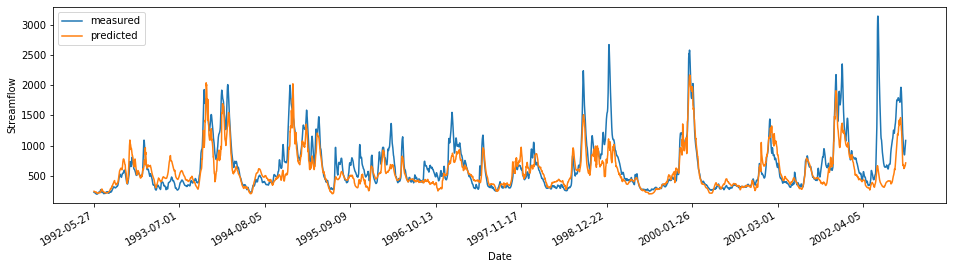

In [62]:
from deephydro.utils import predict_timeseries

maxtime = len(x_val)
ts_pred, ts_gt, df_pred = predict_timeseries(model=model, 
                                    data=x_val[:maxtime], 
                                    doy=x_doy_val[:maxtime], 
                                    df=df_val[:maxtime],
                                    n_frames=n_frames, 
                                    stride=1, 
                                    batch_size=256, 
                                    y_mean=Y_MEAN, y_std=Y_STD,
                                    gt=y_val[:maxtime], 
                                    plot=True)

In [63]:
df_pred.to_csv('../output/df_pred.csv')

(3801,)
(3801,)
(3801,)
(3801,)


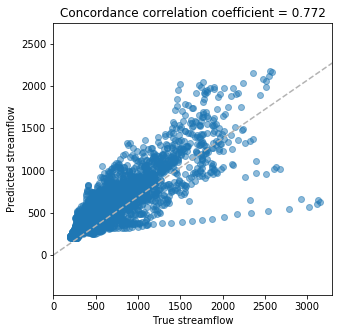

In [61]:
from deephydro.visualization import plot_correlation
plot_correlation(ts_pred, ts_gt)

- predict random samples

In [ ]:
from deephydro.utils import predict_batch
gt, y_pred = predict_batch(model, generator=generator_test, 
                     n_samples=2000, y_mean=Y_MEAN, y_std=Y_STD)

In [ ]:
from deephydro.visualization import plot_correlation
plot_correlation(gt, y_pred)

# Saliency map

- using a variant of `DeepLIFT` called `DeepShap` based on Shapley values and implemented in the package [`shap`](https://github.com/slundberg/shap)


```
conda install -c conda-forge shap
pip install tqdm --upgrade # I needed to upgrade tqdm (progress bar)
```

In [ ]:
# get a batch of images
batch = generator_test.__getitem__(0)
# select a single image
im = batch[0][123]

In [ ]:
from deephydro.utils import saliency_map
shap = saliency_map(model, generator=generator_test, image=im)
print(shap.shape)

In [ ]:
from deephydro.visualization import plot_saliency_map
plot_saliency_map(image=im, shap_values=shap, mask=mask)